# Preparing environment

In [590]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(root_dir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import helpers as hlp
%aimport helpers
%aimport holt
%aimport holtwinters
from external import kMedoids
from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

import helpers as hlp
%aimport helpers
from data import preprocessing as prp
%aimport data.preprocessing

#printing
pd.options.display.float_format = '{:,.2f}'.format

subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Predict Quantities

## Load product cleaned features

In [591]:
! python c:/Users/rahmim00/Documents/Notebooks/Clustering/pc_clustering/src/features/build_features.py

Data set succefully made !
encoders saved


In [592]:
dataframe = prp.load_file("temp",index="Product")
store_counts = prp.load_file("store_counts",index="Product")
store_counts.head()
dataframe = dataframe.join(store_counts,how="left").fillna(0)
dataframe["Missing"] = 1

### Other sales series files

In [618]:
s="all"
clean_df = prp.load_file("product_p2_clean_full_%s"%s, type_= "I",version=1).set_index("Product").astype(np.float64)
zclean_df = prp.load_file("product_z_p2_clean_%s"%s, type_= "P",version=1).set_index("Product").astype(np.float64)


print("Sales: ",clean_df.shape)

#Load cleaned features for classification
filename ="clf_features"
df = prp.load_file(filename,type_="P",index = "Product")
df.Ldate = df.Ldate.apply(lambda x:str(x))

numeric = (list(df.columns.to_series().groupby(df.dtypes).groups[np.dtype('float64')]))

#df.drop_duplicates(inplace=True)
print("Product Features:", df.shape)
df.head()
ohe = prp.encode(df,non_categorical=numeric)
print("Encoded Features", ohe.shape)
df.head(5)

Sales:  (3529, 16)
Product Features: (6815, 11)
Encoded Features (6815, 160)


,Color,Size,Ldate,Age Group,Person,Pname,Ptype,Tprice,Currency,Sales Season,Nstore
Product,,,,,,,,,,,
3.6E+101_2,Other,Thick,36,29-38,Pregnant,One-Piece Pants,Thin,0.13,Y,Autumn,0.00
30E000400_2,Black,Thick,45,4-6,Girls,One Internal Pants,Thick,0.11,$,Winter,0.19
30E823101_2,Grey,No Size,39,4-6,Girls,One Internal Pants,Thick,0.11,$,Winter,0.02
30E823102_2,Grey,No Size,39,7-9,Girls,One Internal Pants,Thick,0.11,$,Winter,0.02
30E823103_2,Grey,No Size,39,10-15,Girls,One Internal Pants,Thick,0.11,$,Winter,0.02


### Missing Values

In [580]:
df[df.Nstore==0].shape

(1418, 11)

### Prepare training data

In [595]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split  
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score,mean_absolute_error




data = df.join(clean_df,how="right")
features = df.columns




X_data = data[features]

series = data.drop(features,axis=1)
y_data = np.array([series.mean(axis=1), series.std(axis = 1)]).T
y_data = np.array(series.std(axis = 1)).T

#Keep the same X with features
# X =  pd.get_dummies(X_data)
X = prp.encode(X_data,non_categorical = numeric)
y = y_data

print(X.shape,y.shape)
X.head()

(3529, 160) (3529,)


,Age Group_10-15,Age Group_18-28,Age Group_29-38,Age Group_39-48,Age Group_4-6,Age Group_7-9,Color_Black,Color_Blue,Color_Brown,Color_Green,...,Sales Season_Spring,Sales Season_Summer,Sales Season_Winter,Person_Boys,Person_Female,Person_Girls,Person_Men,Person_Pregnant,Tprice,Nstore
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.13,0.00
30E000400_2,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.11,0.19
30E823101_2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.11,0.02
30E823102_2,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.11,0.02
30E823103_2,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.11,0.02


### Train regressor

In [605]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
regr = RandomForestRegressor(n_estimators=100,max_depth =12 )


regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
yt_pred = regr.predict(X_train)

MU = "uniform_average"


def adjusted_r2(X,y,r_squared):
    return r_squared
#     return  1 - ((1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1))


# scores = cross_val_score(regr, X, y, cv=10, scoring='r2')
# print(scores,scores.mean())

print("Train")
rmse = math.sqrt(mean_squared_error(yt_pred,y_train,multioutput=MU))
print("RMSE: ",rmse)
r2 = r2_score(yt_pred,y_train,multioutput=MU)
print("R2: ",adjusted_r2(X_train,y_train,r2))
print("\nTest")
rmse = math.sqrt(mean_squared_error(y_pred,y_test,multioutput=MU))
print("RMSE: ",rmse)
r2 = r2_score(y_pred,y_test,multioutput=MU)
print("R2: ",adjusted_r2(X_test,y_test,r2))

Train
RMSE:  195.39272006325365
R2:  0.956057478411

Test
RMSE:  375.8863526479453
R2:  0.87720485919


### Save model

In [606]:
import pickle
from sklearn.externals import joblib

joblib.dump(regr,models_path+'estimator.pkl') 

['C:\\Users\\rahmim00\\Documents\\Notebooks\\Clustering\\pc_clustering\\notebooks\\Cerf7\\..\\..\\models\\7CERF\\estimator.pkl']

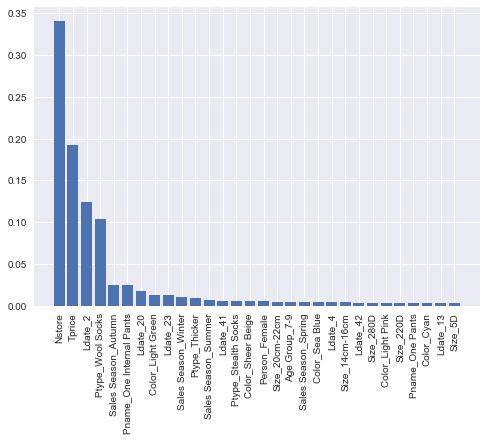

In [93]:
fi = regr.feature_importances_
sorted_indices = np.argsort(fi)[::-1]

imp = sorted_indices[:30]

plt.bar(range(len(imp)),fi[imp])
plt.xticks(range(len(imp)), X.columns[imp],rotation = 90)
plt.show()